# scRNA

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
inputdata.10x <- Read10X("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/filtered_feature_bc_matrix")

10X data contains more than one type and is being returned as a list containing matrices of each type.



In [3]:
sc_RNA <- CreateSeuratObject(counts = inputdata.10x$`Gene Expression`,min.cells = 3, min.features = 200)
sc_RNA[["percent.mt"]] <- PercentageFeatureSet(sc_RNA, pattern = '^mt-')

In [4]:
sc_RNA

An object of class Seurat 
16193 features across 3028 samples within 1 assay 
Active assay: RNA (16193 features, 0 variable features)
 1 layer present: counts

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


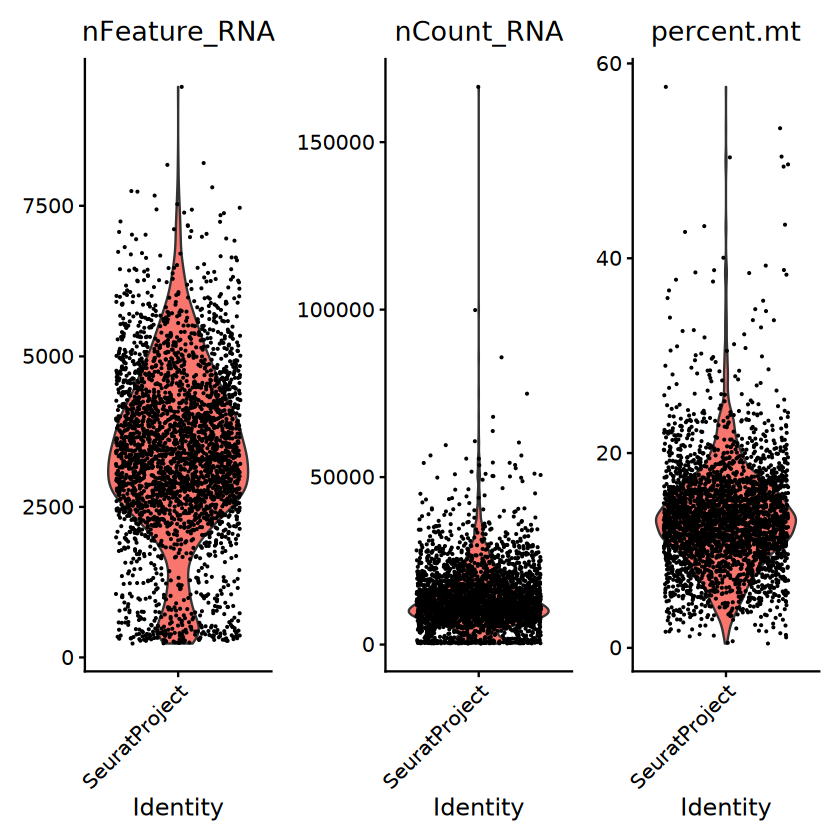

In [5]:
VlnPlot(sc_RNA, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [6]:
sc_RNA <- subset(sc_RNA, subset = nFeature_RNA > 1000 & nFeature_RNA < 7500 & percent.mt < 20)

In [7]:
sc_RNA

An object of class Seurat 
16193 features across 2568 samples within 1 assay 
Active assay: RNA (16193 features, 0 variable features)
 1 layer present: counts

In [8]:
sc_RNA <- NormalizeData(sc_RNA)
sc_RNA <- FindVariableFeatures(sc_RNA, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(sc_RNA)
sc_RNA <- ScaleData(sc_RNA, features = all.genes)
sc_RNA <- RunPCA(sc_RNA, features = VariableFeatures(object = sc_RNA))

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Lgals3, Malat1, Ndrg1, Fn1, Cp, Nupr1, Col6a1, Fos, Bnip3, 2410006H16Rik 
	   Cited2, Aqp5, Itgb5, Mt1, Ero1l, Atf3, Dusp1, F3, Id3, Tmem150a 
	   Cebpb, Neat1, Tcn2, Zfp36l1, Zfp36, Mxra8, B2m, Igfbp7, Junb, P4ha1 
Negative:  Pclaf, Top2a, H2afz, Ccna2, Birc5, Hmgb2, Smc2, Ccnd1, Anln, Racgap1 
	   Tyms, Mki67, Tk1, Hmgb1, Dek, Cks1b, H2afx, Mcm3, Uhrf1, Diaph3 
	   Cenpe, Tmem97, Smc4, Set, Hspd1, Cenpf, Ran, Ranbp1, Ncl, Cdk1 
PC_ 2 
Positive:  Rps2, Ftl1, Ddit3, Atf4, 2410006H16Rik, Snhg16, Ero1l, Gm41609, 1110038B12Rik, Pgk1 
	   5430416N02Rik, Mt1, Cdkn1a, Snhg1, Rps18, Snhg20, Gpi1, Trib3, Hmox1, Bnip3 
	   Slc3a2, Npm1, Ciart, Mthfd2, Hspa9, Pabpc1, Asns, Hist1h4i, Mt2, Slc2a1 
Negative:  mt-Nd3, Col18a1, Fn1, Fbln2, Cp, Sparc, Col6a1, mt-Nd1, Zfpm2, Cdk14 
	   mt-Nd4, Junb, Nfkbiz, Gpc6, mt-Nd2, Cdk6, Msn, Ltbp1, Airn, mt-Atp6 
	   Vcam1, Emilin1, Col4a5,

In [10]:
sc_RNA <- RunUMAP(sc_RNA, dims = 1:30, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [11]:
sc_RNA <- FindNeighbors(sc_RNA, dims = 1:30, verbose = FALSE)
sc_RNA <- FindClusters(sc_RNA, verbose = FALSE)

In [12]:
sc_RNA <- FindClusters(sc_RNA, verbose = FALSE,resolution = 0.8)

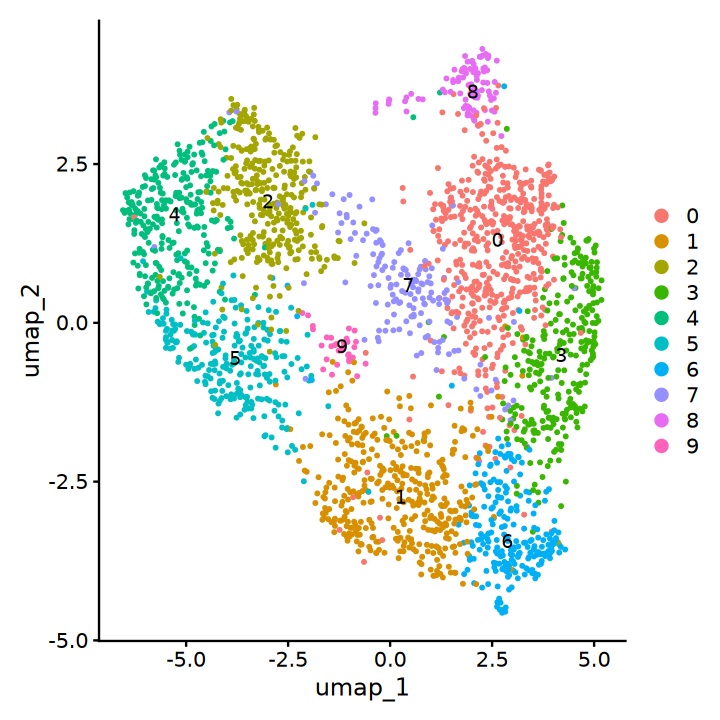

In [13]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_RNA, label = TRUE)

## cluster transfer

In [18]:
sc.all.merge <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scRNA/cellranger/sc.all.merge.T1T2T3a.harmony.final.refine.rds')

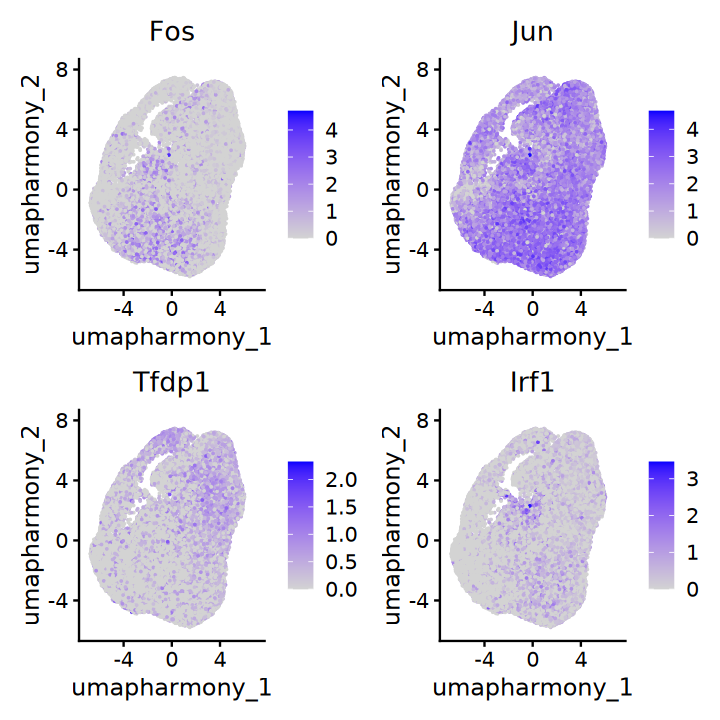

In [19]:
options(repr.plot.width = 6,repr.plot.height = 6)
FeaturePlot(sc.all.merge,features = c('Fos','Jun','Tfdp1','Irf1'),reduction = 'umap.harmony')

In [20]:
sc.all.merge

An object of class Seurat 
32285 features across 91411 samples within 1 assay 
Active assay: RNA (32285 features, 2000 variable features)
 19 layers present: counts.T1_a3026, counts.T1_a3028, counts.T1_a3030, counts.T2_a3026, counts.T2_a3028, counts.T2_a3030, counts.T3_a3026, counts.T3_a3028, counts.T3_a3030, scale.data, data.T1_a3026, data.T1_a3028, data.T1_a3030, data.T2_a3026, data.T2_a3028, data.T2_a3030, data.T3_a3026, data.T3_a3028, data.T3_a3030
 4 dimensional reductions calculated: pca, umap, harmony, umap.harmony

In [24]:
sc.all.merge <- JoinLayers(sc.all.merge)

In [26]:
sc_RNA.anchors <- FindTransferAnchors(reference = sc.all.merge, query = sc_RNA, dims = 1:50,normalization.method = 'LogNormalize',reference.reduction = "pca",recompute.residuals = FALSE)
predictions <- TransferData(anchorset = sc_RNA.anchors, refdata = sc.all.merge$seurat_clusters_rename, dims = 1:50)
sc_RNA <- AddMetaData(sc_RNA, metadata = predictions)

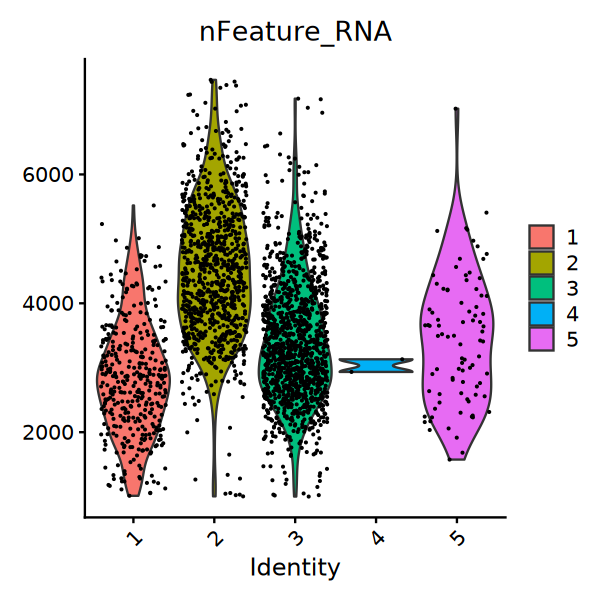

In [30]:
VlnPlot(sc_RNA,group.by = 'predicted.id',features = "nFeature_RNA")

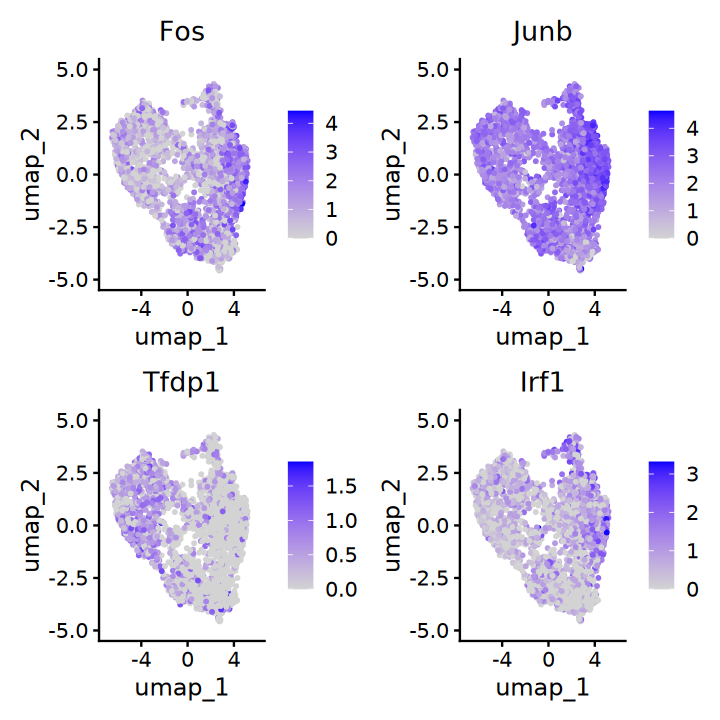

In [364]:
options(repr.plot.width = 6,repr.plot.height = 6)
FeaturePlot(sc_RNA,features = c('Fos','Junb','Tfdp1','Irf1'))

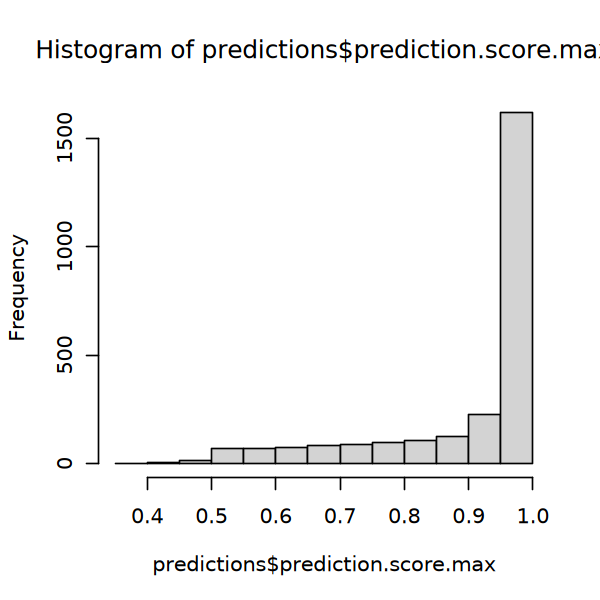

In [31]:
hist(predictions$prediction.score.max)

In [32]:
sc_RNA@meta.data <- cbind(sc_RNA@meta.data,
                      as.data.frame(sc_RNA@reductions$umap@cell.embeddings)[rownames(sc_RNA@meta.data),])

In [33]:
sc_RNA@meta.data

orig.ident    nCount_RNA nFeature_RNA percent.mt
AAACAGCCAGGCCATT-1 SeuratProject 59544      7436         13.786444 
AAACATGCACCCTCAC-1 SeuratProject 11604      3725         10.617029 
AAACATGCAGGCTACT-1 SeuratProject 17107      4309         17.793886 
AAACCGCGTCTTGCTG-1 SeuratProject 17680      4029         19.049774 
AAACCGCGTGGTTCTT-1 SeuratProject  9952      2878         18.488746 
AAACCGGCAAGGACCA-1 SeuratProject 14508      3857          8.422939 
AAACCGGCACAAAGGT-1 SeuratProject 15842      3891         17.624037 
AAACCGGCAGTGAACG-1 SeuratProject 10179      3167         15.404264 
AAACGGATCCAGGTTG-1 SeuratProject  4288      1633          8.115672 
AAACGGATCCTGATGG-1 SeuratProject 37873      5965         12.164339 
AAACGTACAATATGGA-1 SeuratProject 15013      3881         13.981216 
AAAGCACCAATAAGCA-1 SeuratProject 14584      3778         10.682940 
AAAGCCGCAAATTGCT-1 SeuratProject 12987      3905          5.390005 
AAAGCCGCAGCCTGCA-1 SeuratProject 20285      5752          2.923342 
AAAGGACGTCATTGAG-1 SeuratProject 15112      3943          4.162255 
AAAGGACGTGACATGC-1 SeuratProject 40102      6034         10.386016 
AAAGGAGCATGTTGTG-1 SeuratProject 11116      3360         10.687298 
AAAGGCTCAAACTGCC-1 SeuratProject  7039      2421         12.146612 
AAAGGCTCAGGTATTT-1 SeuratProject 25477      5231         13.938062 
AAAGGTTAGCGTGCAC-1 SeuratProject 10604      3350          6.233497 
AAAGGTTAGCTCGCTT-1 SeuratProject  6724      2126         13.518739 
AAAGGTTAGGAGGTTA-1 SeuratProject 15783      4362         11.119559 
AAATCCGGTTAGGTGC-1 SeuratProject 18001      4371         15.193600 
AAATGCCTCTACCTCA-1 SeuratProject 11808      3498         19.774729 
AAATGGCCAAGTGAAC-1 SeuratProject 15006      3900         17.473011 
AAATGGCCAGGTATTT-1 SeuratProject 22039      4804         19.225010 
AAATGGCCATAAGTCT-1 SeuratProject  8802      2760         14.587594 
AACAAAGGTACGCGCA-1 SeuratProject 11935      3540          4.155844 
AACAAAGGTGTTAAAC-1 SeuratProject 12284      3576          8.498860 
AACAGATAGGATTTGC-1 SeuratProject 12254      3478         11.620695 
⋮                  ⋮             ⋮          ⋮            ⋮         
TTTAGGATCTACCTCA-1 SeuratProject  9528      2889          4.481528 
TTTATGGAGGCTAAGA-1 SeuratProject 14408      3765         14.415602 
TTTCATCAGACAACAG-1 SeuratProject  7865      2610          8.213605 
TTTCATCAGCCTGGTA-1 SeuratProject 14050      3846         18.341637 
TTTCATCAGGACTAAG-1 SeuratProject  7689      2545         18.532969 
TTTCATCAGTCCTTTG-1 SeuratProject 25653      5289         11.608779 
TTTCCACCATAATCAC-1 SeuratProject 14142      3839         11.264319 
TTTCCTGAGCTATTGA-1 SeuratProject 10522      3355         14.607489 
TTTCCTGAGTCTGGGC-1 SeuratProject 14571      3641         16.148514 
TTTCGTCCACAGCCAT-1 SeuratProject 16123      3807         15.437574 
TTTCGTCCACGTAATT-1 SeuratProject  8143      2742          5.071841 
TTTCTTGCAACCTAAT-1 SeuratProject 25517      5404         11.016185 
TTTCTTGCACCGGTAT-1 SeuratProject 21425      4708         14.753792 
TTTGACTTCAAGACTC-1 SeuratProject 12769      3691          9.374266 
TTTGACTTCTGTGAGT-1 SeuratProject 13205      3457         17.803862 
TTTGAGTCACCATATG-1 SeuratProject 26574      5139         12.041845 
TTTGCATTCAAGCCTG-1 SeuratProject 10073      2717          9.838181 
TTTGCATTCATTACAG-1 SeuratProject 20968      4855         14.989508 
TTTGCGACAGTCTAAT-1 SeuratProject 13400      3711          8.111940 
TTTGCGGAGTCATCCC-1 SeuratProject 16830      4322         11.111111 
TTTGTCCCAAGGTAAC-1 SeuratProject 20318      4793         15.429668 
TTTGTCCCAGGCTAAG-1 SeuratProject 10596      3503         11.192903 
TTTGTCTAGAAAGCAT-1 SeuratProject 17413      4054         14.931373 
TTTGTCTAGGAGCAAC-1 SeuratProject 26705      5279         19.408350 
TTTGTCTAGGCAAGTA-1 SeuratProject  9318      2922          9.948487 
TTTGTCTAGTCTCACC-1 SeuratProject 21752      4947         11.511585 
TTTGTGAAGTTTGCGG-1 SeuratProject 13142      3660          8.088571 
TTTGTGG

In [34]:
table(sc_RNA@meta.data$predicted.id)


   1    2    3    4    5 
 377  868 1235    2   86 

In [35]:
saveRDS(sc_RNA,file='/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA.rds')

In [36]:
write.table(sc_RNA@meta.data,'/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',col.names = NA,quote=F,sep=',')

In [1]:
library(Seurat)
library(ggplot2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
sc_RNA <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA.rds')
sc_RNA

An object of class Seurat 
16193 features across 2568 samples within 1 assay 
Active assay: RNA (16193 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [3]:
table(sc_RNA@meta.data$predicted.id)


   1    2    3    4    5 
 377  868 1235    2   86 

In [ ]:
options(repr.plot.width = 5,repr.plot.height = 5) 
DimPlot(sc_RNA, label = TRUE,group.by = 'predicted.id',cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))

In [4]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_UMAP.pdf',width=5,height=5)
options(repr.plot.width = 5,repr.plot.height = 5) 
DimPlot(sc_RNA, label = TRUE,group.by = 'predicted.id',cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))
dev.off()

png 
  2

In [4]:
sc_RNA <- subset(sc_RNA,predicted.id %in% c(1,2,3,5))
sc_RNA

An object of class Seurat 
16193 features across 2566 samples within 1 assay 
Active assay: RNA (16193 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [10]:
df <- FetchData(sc_RNA, vars=c('Fosb','Jun','Hmga1','Irf1','predicted.id'))
#df <- df[df$time!='T1',]
df

Fosb      Jun       Hmga1     Irf1      predicted.id
AAACAGCCAGGCCATT-1 0.8516644 2.3895550 1.3493792 0.5138842 2           
AAACATGCACCCTCAC-1 1.6693769 1.6693769 0.6215286 2.1697330 3           
AAACATGCAGGCTACT-1 0.7743179 1.8343406 1.8343406 0.4603043 3           
AAACCGCGTCTTGCTG-1 1.8067298 2.5984912 0.7566954 0.0000000 3           
AAACCGCGTGGTTCTT-1 0.0000000 1.7957707 0.0000000 2.3069165 2           
AAACCGGCAAGGACCA-1 1.1209687 3.1076100 1.8739843 0.0000000 2           
AAACCGGCACAAAGGT-1 1.4245933 1.8000364 0.8164557 1.0625361 3           
AAACCGGCAGTGAACG-1 0.0000000 1.3730177 1.7769967 0.0000000 2           
AAACGGATCCAGGTTG-1 0.0000000 1.2035996 1.2035996 1.2035996 3           
AAACGGATCCTGATGG-1 0.7208408 1.6015277 0.5833999 0.4240125 2           
AAACGTACAATATGGA-1 2.3345925 2.8708624 1.0980348 2.2679069 2           
AAAGCACCAATAAGCA-1 0.0000000 2.1450551 0.8634661 0.0000000 2           
AAAGCCGCAAATTGCT-1 0.0000000 1.9685108 1.4060977 0.9321647 3           
AAAGCCGCAGCCTGCA-1 0.0000000 1.4930896 0.0000000 1.0892016 2           
AAAGGACGTCATTGAG-1 0.0000000 1.0936592 0.5078567 0.0000000 5           
AAAGGACGTGACATGC-1 1.2509445 2.3002933 1.0099810 0.2226347 3           
AAAGGAGCATGTTGTG-1 0.0000000 1.8559268 1.3080118 1.3080118 2           
AAAGGCTCAAACTGCC-1 1.6605053 2.8110411 0.0000000 0.0000000 3           
AAAGGCTCAGGTATTT-1 0.3311085 2.2238372 1.2104712 0.3311085 2           
AAAGGTTAGCGTGCAC-1 0.6642539 1.7431296 0.6642539 0.0000000 2           
AAAGGTTAGCTCGCTT-1 0.0000000 0.9111616 0.0000000 0.0000000 1           
AAAGGTTAGGAGGTTA-1 0.0000000 2.0756248 1.0649794 0.0000000 2           
AAATCCGGTTAGGTGC-1 1.3290951 2.3460200 1.3290951 0.0000000 3           
AAATGCCTCTACCTCA-1 0.0000000 2.6176332 0.0000000 0.0000000 3           
AAATGGCCAAGTGAAC-1 1.4660295 2.7076769 1.0983457 0.0000000 3           
AAATGGCCAGGTATTT-1 0.0000000 2.0549076 1.1843940 1.8632881 3           
AAATGGCCATAAGTCT-1 2.1919594 3.2578780 0.0000000 0.7589843 3           
AACAAAGGTACGCGCA-1 0.0000000 1.4705177 1.4705177 0.0000000 2           
AACAAAGGTGTTAAAC-1 1.2361112 2.8496274 1.4483928 0.5955713 2           
AACAGATAGGATTTGC-1 0.0000000 1.7743353 1.2378466 0.9677897 2           
⋮                  ⋮         ⋮         ⋮         ⋮         ⋮           
TTTAGGATCTACCTCA-1 0.0000000 2.2403166 0.7176145 0.0000000 1           
TTTATGGAGGCTAAGA-1 0.0000000 0.5271273 0.5271273 0.0000000 3           
TTTCATCAGACAACAG-1 2.4133790 2.8638524 1.2649489 1.8059620 3           
TTTCATCAGCCTGGTA-1 0.5375126 1.6621181 0.5375126 0.5375126 3           
TTTCATCAGGACTAAG-1 0.8331522 2.4340057 0.0000000 0.0000000 3           
TTTCATCAGTCCTTTG-1 1.0814966 2.2991605 0.9397228 0.0000000 2           
TTTCCACCATAATCAC-1 1.1382626 2.2497498 1.1382626 0.5348040 3           
TTTCCTGAGCTATTGA-1 0.6680292 1.3483767 0.0000000 0.6680292 2           
TTTCCTGAGTCTGGGC-1 0.5225336 1.9708330 1.4887321 0.8639819 2           
TTTCGTCCACAGCCAT-1 1.2472989 3.1227225 1.6755297 1.0510649 2           
TTTCGTCCACGTAATT-1 1.2401400 2.2613818 1.5441836 0.8011261 3           
TTTCTTGCAACCTAAT-1 0.0000000 1.9838016 1.2093703 0.3306666 2           
TTTCTTGCACCGGTAT-1 1.5547611 1.6487933 0.6593261 0.3830453 3           
TTTGACTTCAAGACTC-1 1.5924410 2.1783211 0.9424626 0.5783796 3           
TTTGACTTCTGTGAGT-1 0.0000000 2.6300102 1.8407119 0.0000000 3           
TTTGAGTCACCATATG-1 1.1810662 1.7075971 1.2903763 0.7556162 2           
TTTGCATTCAAGCCTG-1 0.6895171 1.9396790 0.0000000 0.0000000 1           
TTTGCATTCATTACAG-1 1.2192316 1.5718062 0.8882005 0.0000000 3           
TTTGCGACAGTCTAAT-1 1.7006692 2.2980974 0.9133012 0.0000000 3           
TTTGCGGAGTCATCCC-1 0.7831497 2.6010378 1.3789891 0.4663577 2           
TTTGTCCCAAGGTAAC-1 0.9068557 2.0012459 0.4002344 1.2415206 3           
TTTGTCCCAGGCTAAG-1 1.0603927 2.8896794 0.0000000 0.0000000 3           
TTTGTCTAGAAAGCAT-1 1.1930537 2.3212633 0.7648012 0.4538003 3           
TTTGTCTAGGAGCAAC-1 0.0000000 1.3852172 0.7530116 0.0000000 

In [11]:
library(tidyr)

In [12]:
df <- pivot_longer(data = df,cols = -c(predicted.id),names_to = 'gene',values_to = 'Expression_Level')

In [16]:
table(df$predicted.id)


   1    2    3    5 
1508 3472 4940  344 

png 
  2

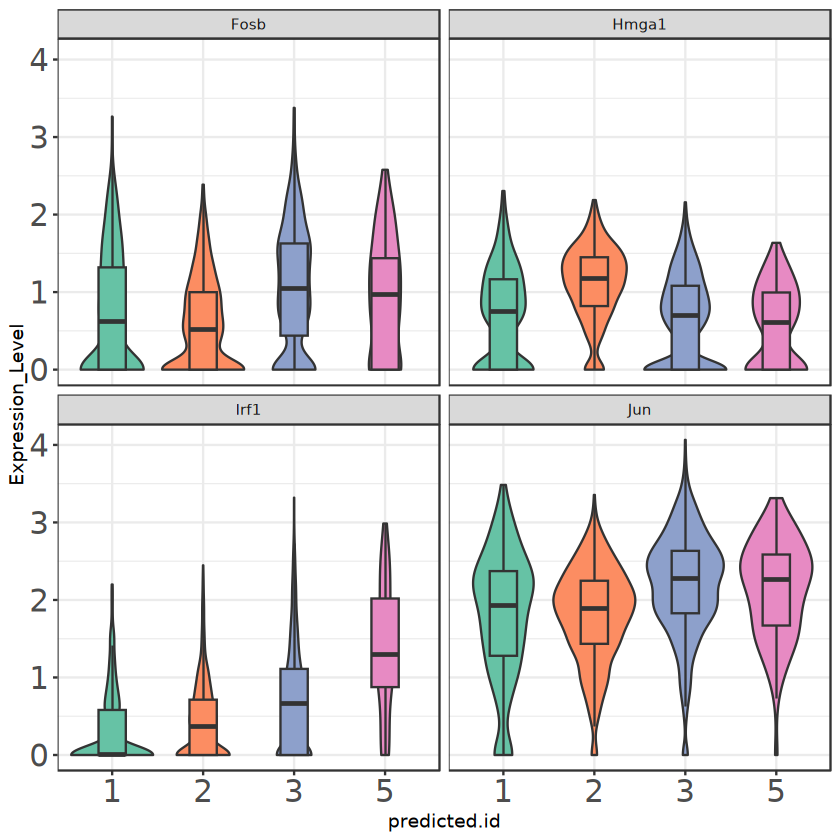

In [15]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_gene_exp.pdf',width=5,height=5)
plot <- ggplot(df,aes(x=predicted.id,y=Expression_Level,fill=predicted.id))+geom_violin(trim = T) +  # 小提琴图
  geom_boxplot(width = 0.3, outlier.shape = NA) +  # 盒型图
  scale_fill_brewer(palette = "Set2") +  facet_wrap(~gene)+
  theme_bw()+
  theme(
    legend.position = "none",
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text = element_text(face = "bold",size = 18)
  )
print(plot)
dev.off()
print(plot)

png 
  2

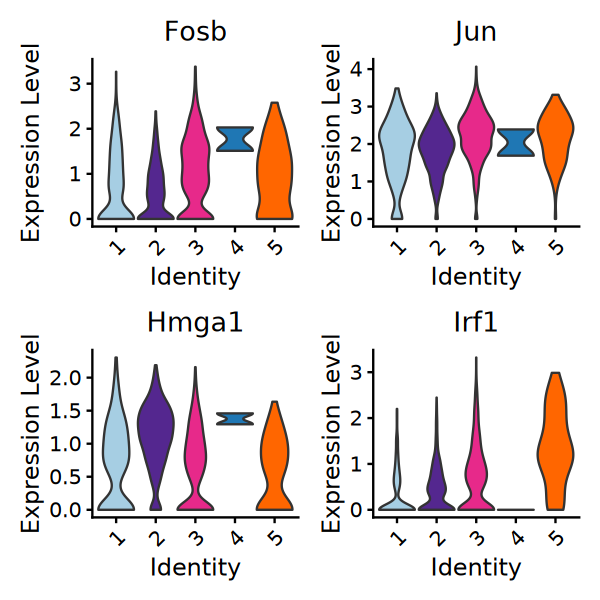

In [23]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_TF_exp.pdf',width=5,height=5)
plot <- VlnPlot(sc_RNA,features = c('Fosb','Jun','Hmga1','Irf1'),group.by = 'predicted.id',pt.size = 0,ncol = 2,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))
print(plot)
dev.off()
print(plot)

png 
  2

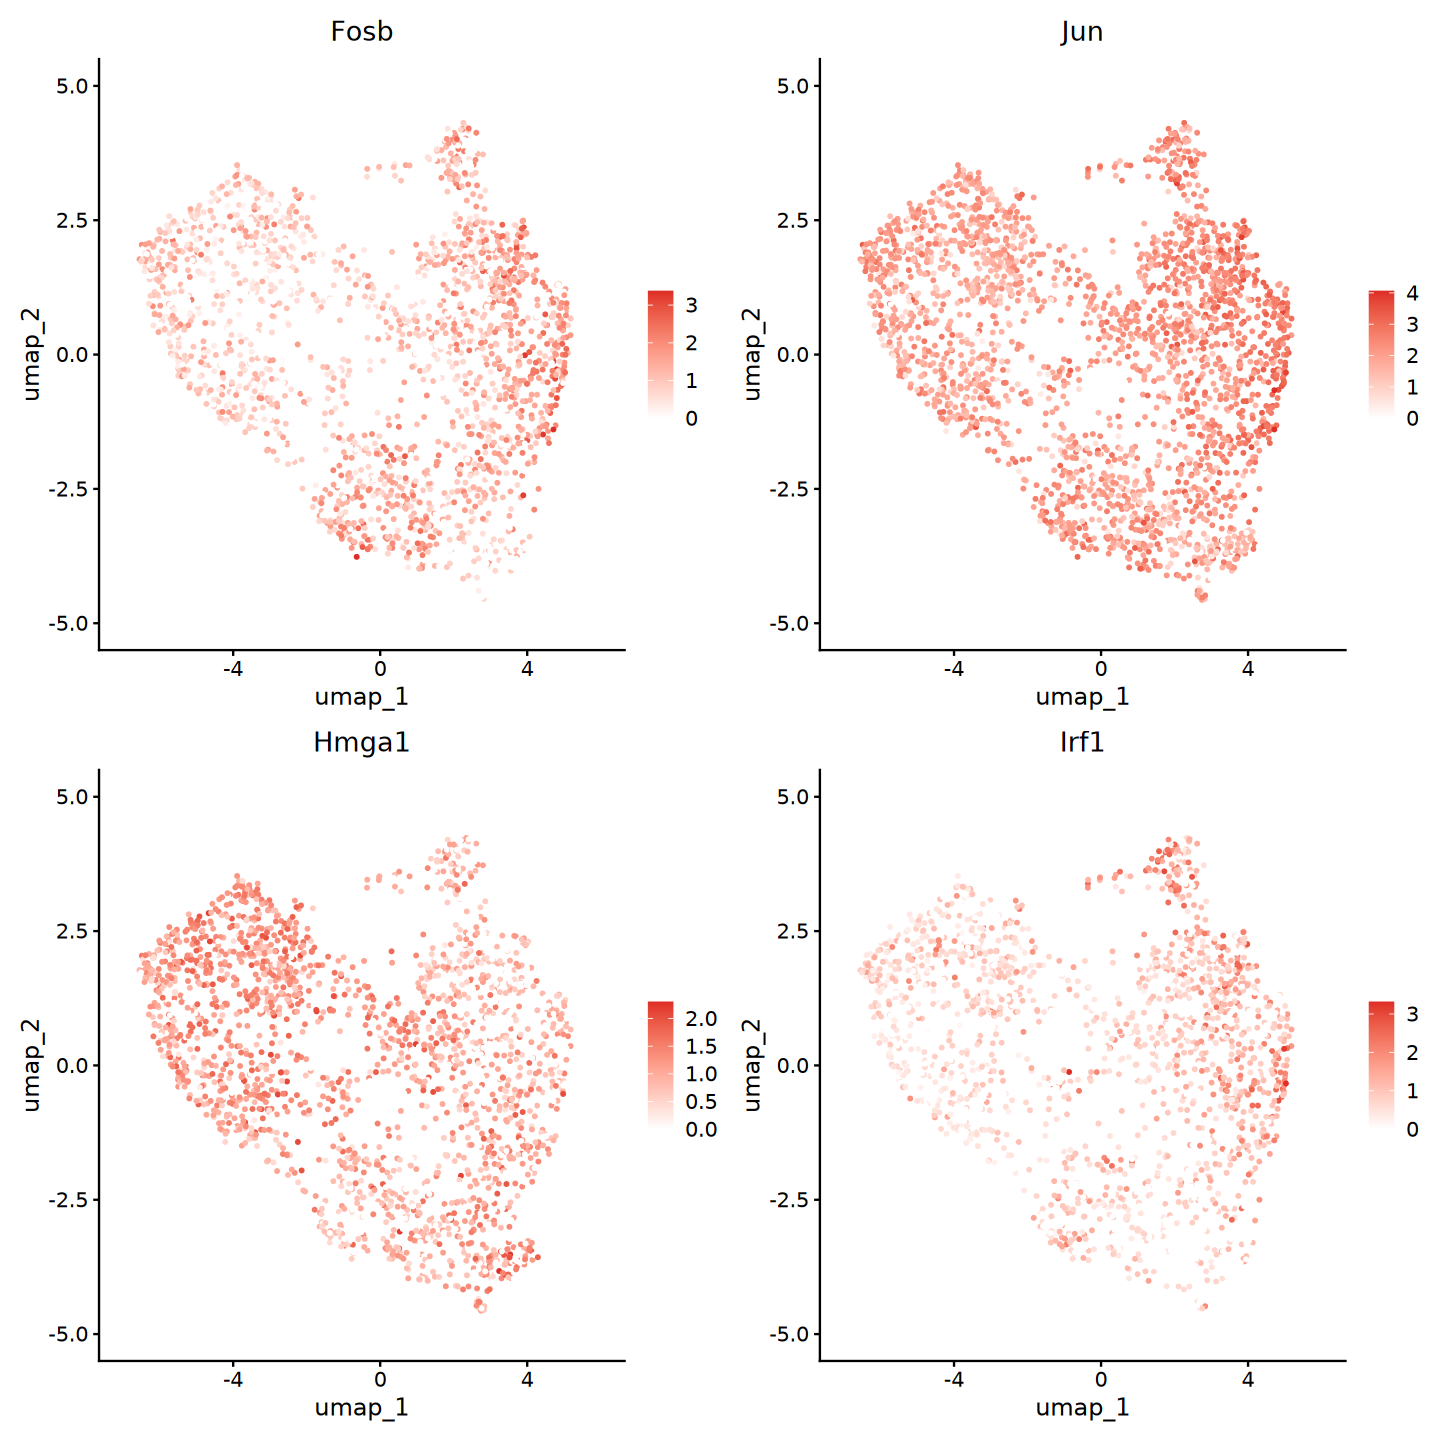

In [12]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_tf_exp.pdf',width=12,height=12)
options(repr.plot.width = 12,repr.plot.height = 12)
plot <- FeaturePlot(sc_RNA,features = c('Fosb','Jun','Hmga1','Irf1'),cols=c('white',"#de2d26"))
print(plot)
dev.off()
print(plot)

png 
  2

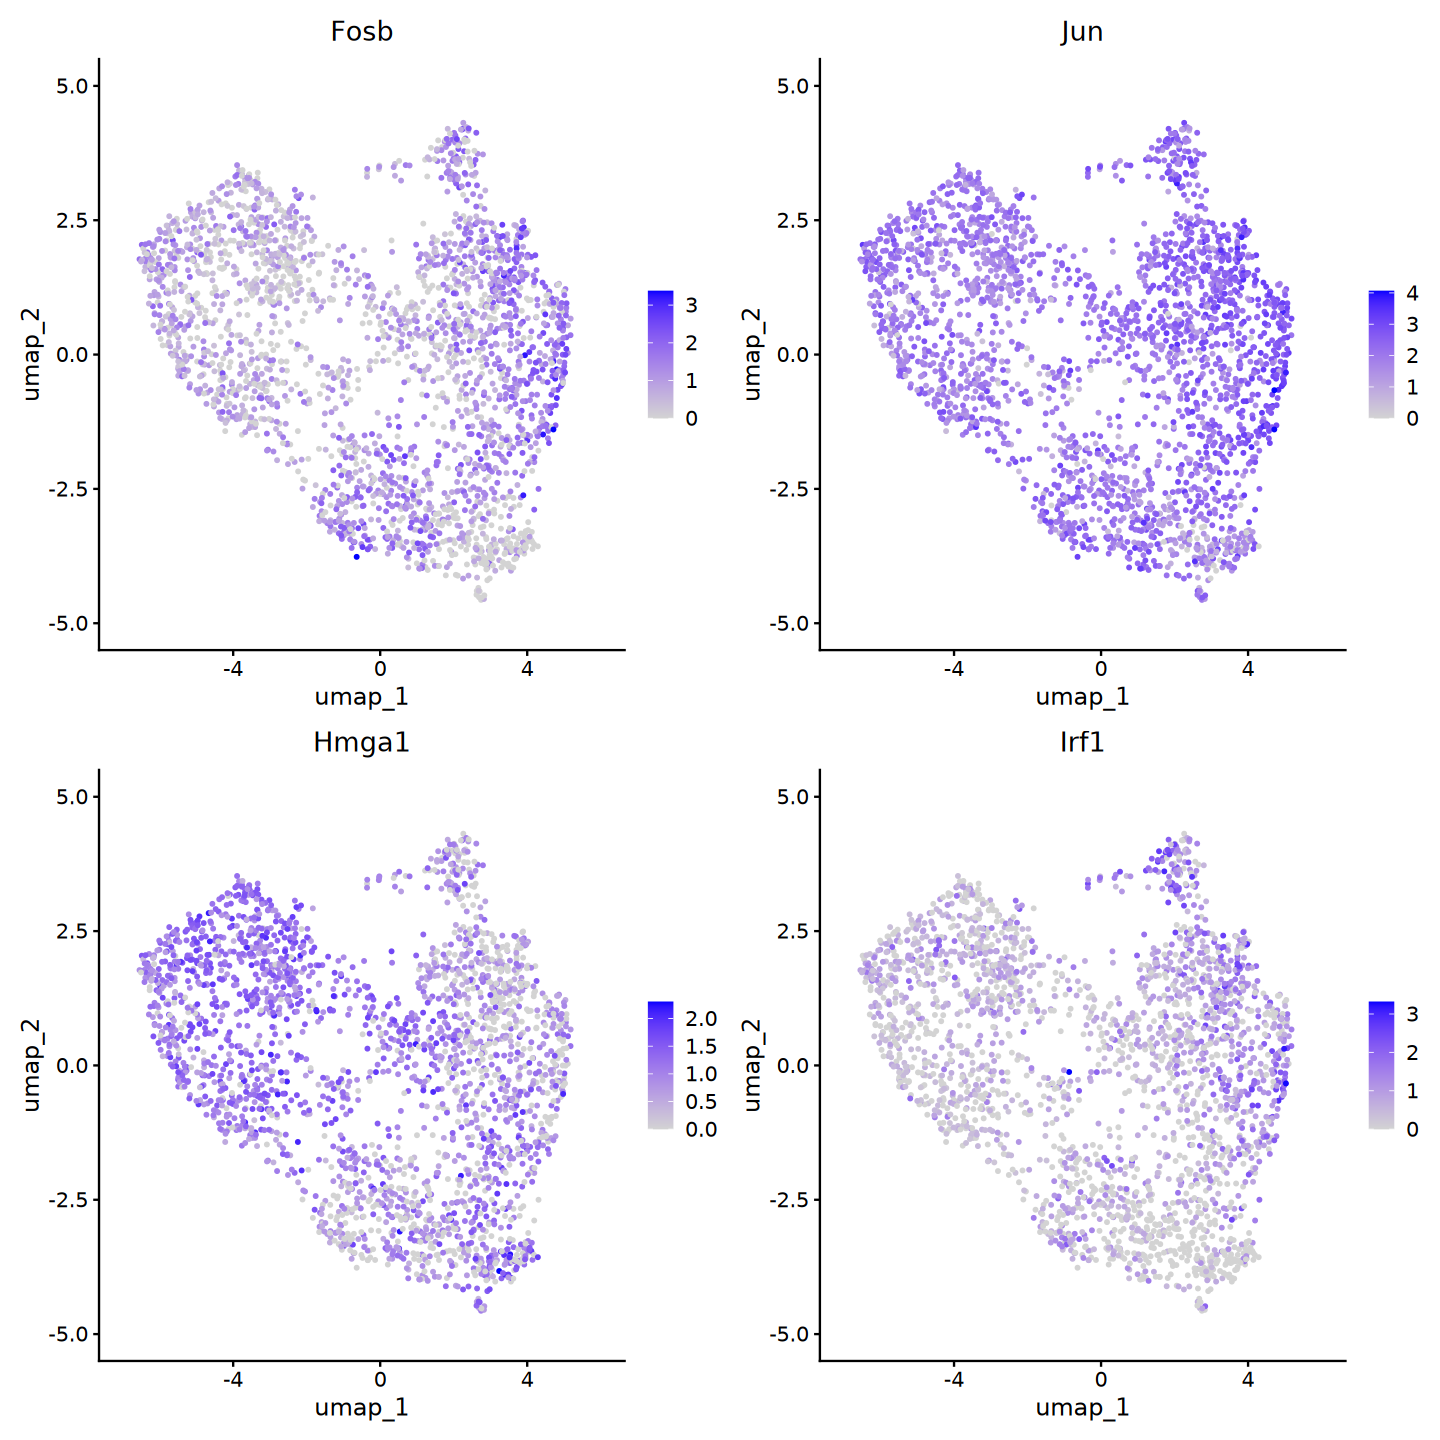

In [15]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/multiome_tf_exp.pdf',width=12,height=12)
options(repr.plot.width = 12,repr.plot.height = 12)
plot <- FeaturePlot(sc_RNA,features = c('Fosb','Jun','Hmga1','Irf1'))
print(plot)
dev.off()
print(plot)

In [5]:
sc_RNA

An object of class Seurat 
16193 features across 2568 samples within 1 assay 
Active assay: RNA (16193 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [6]:
genes <- c('Gapdh','Acta1','Hsp90b1','Calr','Rpl39','Cfl1','Myl6','Calm2','Hsp90ab1','Fth1','Hint1','Tpt1','Lgals1','Slc25a3','Calm1','Btf3')

In [9]:
df <- as.data.frame(t(as.data.frame(as.matrix(sc_RNA@assays$RNA@layers$data[rownames(sc_RNA) %in% genes,]))))
df$cellBC <- rownames(df)
colnames(df) <- c(rownames(sc_RNA)[rownames(sc_RNA) %in% genes],'cellBC')
df

Gapdh    Calr      Acta1 Hsp90b1   Slc25a3  Myl6      Hint1    Calm1   
V1    2.897578 2.2755261 0     2.0435192 1.392022 2.2223733 2.222373 2.994610
V2    2.693840 2.6938396 0     2.2636070 1.276846 1.4922493 1.669377 2.263607
V3    2.980913 1.3668006 0     1.5057063 1.205439 1.7363257 2.151672 2.444259
V4    3.451351 1.8955350 0     2.3623043 2.052498 2.1881336 2.122614 3.486586
V5    3.262723 1.6132890 0     1.7957707 1.389905 2.0836529 1.613289 2.402270
V6    2.693647 1.9745634 0     1.4920890 0.866491 1.6362063 2.693647 3.327971
V7    3.083317 0.8164557 0     1.4245933 1.424593 1.8000364 1.989563 2.611882
V8    2.873624 1.7769967 0     2.1814698 1.595270 1.7769967 1.595270 2.468656
V9    3.366781 1.7341620 0     0.0000000 1.203600 2.3348933 2.852129 3.366781
V10   3.411427 1.3621153 0     0.8416541 1.878678 1.7026889 2.158388 3.261316
V11   3.134666 1.7338877 0     0.5104792 1.733888 2.3971078 1.945168 2.511510
V12   3.005639 2.2222635 0     1.7578201 2.061383 2.2939356 2.222264 2.777889
V13   2.843165 1.4060977 0     0.9321647 1.196949 2.5297216 2.326303 3.008156
V14   2.660982 1.5981344 0     1.0892016 1.242677 2.0670718 1.859843 3.121964
V15   4.236390 1.4606197 0     1.4606197 1.093659 1.8395660 1.839566 2.505472
V16   3.704972 2.1079755 0     1.8304426 1.869648 2.5431845 2.137819 3.274694
V17   3.194161 1.8559268 0     2.3021892 1.525712 2.2078829 1.987495 3.299110
V18   3.473656 1.8995109 0     0.0000000 1.660505 2.9687994 1.899511 2.392846
V19   2.663427 2.4163854 0     2.0875580 1.871056 2.7916512 1.671026 3.936548
V20   3.680460 1.7431296 0     2.3447250 1.342635 2.8889667 2.717710 3.931456
V21   4.682864 0.9111616 0     1.3798788 1.697747 1.6977473 1.379879 2.132514
V22   2.703978 1.4274280 0     2.2231858 1.992784 1.8031518 2.152125 2.930693
V23   2.494072 1.1700329 0     1.6945504 1.791713 2.2913619 1.791713 2.346020
V24   2.734174 1.2643104 0     1.4787673 1.478767 2.2480058 2.412569 2.787718
V25   2.662216 2.1968691 0     1.9455674 1.734272 0.5106657 1.609118 1.845490
V26   2.475680 1.1843940 0     1.9313235 1.711527 1.4293988 2.054908 2.584074
V27   3.117330 1.7127923 0     1.4834928 1.483493 2.3114302 1.899197 1.899197
V28   3.126088 0.9842273 0     0.9842273 2.144860 1.7962877 3.009194 2.966982
V29   3.384131 1.6234070 0     2.6972683 1.448393 1.9018791 2.212734 2.212734
V30   2.897968 1.9039596 0     2.3788719 2.214912 2.2149117 1.903960 2.984134
⋮     ⋮        ⋮         ⋮     ⋮         ⋮        ⋮         ⋮        ⋮       
V2539 3.897493 1.8322120 0     2.2403166 1.987495 1.1311041 1.832212 2.240317
V2540 3.535577 1.6417799 0     1.3287276 2.155783 2.6523344 2.371815 3.685556
V2541 3.321453 1.9956902 0     1.2649489 1.995690 2.1550979 2.292554 2.933877
V2542 2.812912 1.3472871 0     2.0022492 1.517042 2.5167202 2.002249 1.788789
V2543 3.020834 1.2812445 0     0.0000000 1.589578 2.3129229 1.281244 2.312923
V2544 2.854880 2.1290101 0     2.7358770 1.923850 1.6654396 2.477790 2.337530
V2545 3.703728 1.8956552 0     2.4515828 1.342461 1.9966063 1.996606 2.451583
V2546 2.351746 1.7495386 0     1.7495386 1.064979 2.3517463 2.785396 3.129343
V2547 3.103471 1.8703176 0     1.6327184 1.758558 2.2947375 2.820472 3.191875
V2548 3.972167 1.5521036 0     2.1333121 1.411270 2.6408323 2.548226 2.446161
V2549 3.696291 1.9657468 0     0.8011261 1.544184 0.8011261 2.124450 2.381802
V2550 2.576328 1.8074102 0     2.3039440 1.593096 2.8139600 2.036302 3.166738
V2551 2.575308 2.0194822 0     1.5547611 1.053258 1.8138779 2.136284 3.883787
V2552 3.132364 1.5924410 0     2.0854634 1.208793 2.4142076 2.414208 2.859115
V2553 2.630010 1.1853607 0     1.3935568 1.393557 2.3112937 2.148605 2.383682
V2554 3.280495 2.0979990 0     1.7075971 1.707597 2.0979990 1.835506 3.176167
V2555 4.255509 1.0937692 0     1.0937692 1.785702 0.6895171 1.603623 1.380844
V2556 2.399282 1.5718062 0     2.0984789 1.351057 2.1553228 2.098479 2.308709
V2557 4.392605 0.9133012 0     2.8994515 1.382556 3.0156812 1.700669 2.767914
V2558 2.725251 1.5184322 0  

In [10]:
library(tidyverse)

Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [11]:
df.long <- pivot_longer(
  data = df,
  cols = -c(cellBC),  # Specify the columns to pivot
  names_to = "Gene",           # Name of the new column containing the original column names
  values_to = "Expression_Level"          # Name of the new column containing the values
)

In [12]:
library(ggplot2)

In [13]:
df.long$Gene <- factor(df.long$Gene,levels=genes)

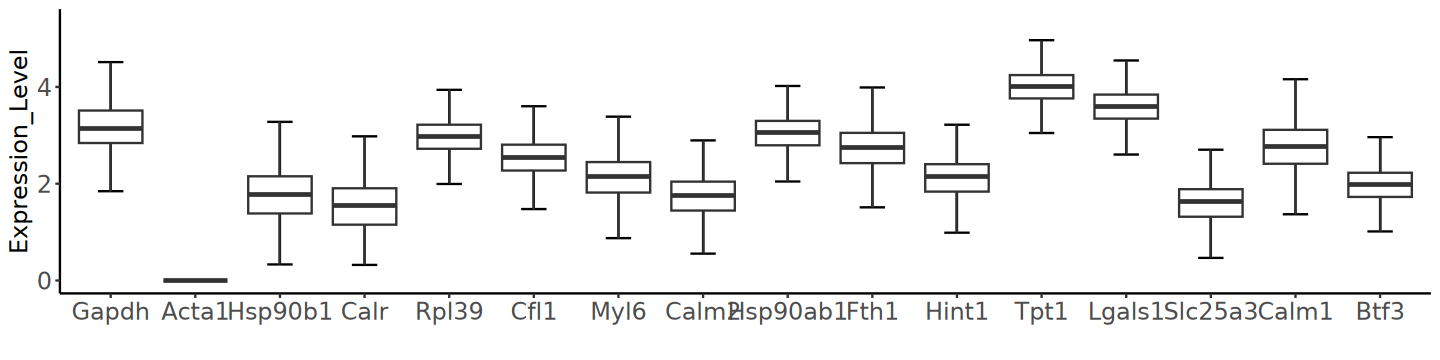

In [14]:
options(repr.plot.width = 12, repr.plot.height = 3)
plot <- ggplot(df.long,aes(x=Gene,y=Expression_Level))+stat_boxplot(geom = "errorbar",width=0.3)+geom_boxplot(outlier.shape = NA)  + xlab('') +theme_classic()+
    theme(axis.title=element_text(size=14),axis.text = element_text(size = 14))
print(plot)


# scATAC and scRNA

In [165]:
# https://satijalab.org/seurat/articles/weighted_nearest_neighbor_analysis

In [6]:
library(Seurat)
library(Signac)
library(EnsDb.Mmusculus.v79)
library(dplyr)
library(ggplot2)
library("BSgenome.Mmusculus.UCSC.mm10")

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:b

In [12]:
inputdata.10x <- Read10X_h5("/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/filtered_feature_bc_matrix.h5")
rna_counts <- inputdata.10x$`Gene Expression`
atac_counts <- inputdata.10x$Peaks

In [ ]:
sc <- CreateSeuratObject(counts = rna_counts)
sc[["percent.mt"]] <- PercentageFeatureSet(sc, pattern = "^mt-")

In [ ]:
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "mm10"

In [ ]:
annotations[1:10,]

In [ ]:
frag.file <- "/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/scATAC_and_scRNA/outs/atac_fragments.tsv.gz"
chrom_assay <- CreateChromatinAssay(
   counts = atac_counts,
   sep = c(":", "-"),
   genome = 'mm10',
   fragments = frag.file,
   min.cells = 10,
   annotation = annotations
 )
sc[["ATAC"]] <- chrom_assay

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 4)
VlnPlot(sc, features = c("nCount_ATAC", "nFeature_RNA", "percent.mt"), ncol = 3,log = TRUE, pt.size = 0) + NoLegend()

In [ ]:
sc

In [ ]:
predictions <- read.table('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',sep=',',header=T,row.names = 1)
sc_filtered <- subset(sc,cells = colnames(sc)[colnames(sc) %in% rownames(predictions)])
sc_filtered@meta.data$celltype <- predictions[colnames(sc_filtered),'predicted.id']

In [ ]:
sc_filtered

In [ ]:
saveRDS(sc_filtered,file='/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/sc_multiome.rds')

In [4]:
sc_filtered <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/sc_multiome.rds')

In [5]:
sc_filtered 

An object of class Seurat 
187457 features across 2568 samples within 2 assays 
Active assay: RNA (32285 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [7]:
sc_filtered <- subset(
  x = sc_filtered,
  subset = 
    nCount_ATAC > 5000 &
    nFeature_RNA > 1000 &
    percent.mt < 30
)

In [11]:
sc_filtered@meta.data

orig.ident    nCount_RNA nFeature_RNA percent.mt nCount_ATAC
AAACAGCCAGGCCATT-1 SeuratProject 59551      7443         13.784823  272842     
AAACATGCACCCTCAC-1 SeuratProject 11605      3726         10.616114  122571     
AAACATGCAGGCTACT-1 SeuratProject 17110      4312         17.790766   95600     
AAACCGCGTCTTGCTG-1 SeuratProject 17681      4030         19.048696   77848     
AAACCGCGTGGTTCTT-1 SeuratProject  9953      2879         18.486888   81446     
AAACCGGCAAGGACCA-1 SeuratProject 14510      3859          8.421778   72373     
AAACCGGCACAAAGGT-1 SeuratProject 15852      3900         17.612920  181208     
AAACCGGCAGTGAACG-1 SeuratProject 10179      3167         15.404264  101477     
AAACGGATCCAGGTTG-1 SeuratProject  4291      1636          8.109998   25099     
AAACGGATCCTGATGG-1 SeuratProject 37895      5984         12.157277  202025     
AAACGTACAATATGGA-1 SeuratProject 15015      3883         13.979354   82261     
AAAGCACCAATAAGCA-1 SeuratProject 14586      3780         10.681475   89281     
AAAGCCGCAAATTGCT-1 SeuratProject 12989      3907          5.389175  114729     
AAAGCCGCAGCCTGCA-1 SeuratProject 20304      5766          2.920607  139332     
AAAGGACGTCATTGAG-1 SeuratProject 15113      3944          4.161980   70418     
AAAGGACGTGACATGC-1 SeuratProject 40106      6038         10.384980  277869     
AAAGGAGCATGTTGTG-1 SeuratProject 11116      3360         10.687298  112675     
AAAGGCTCAAACTGCC-1 SeuratProject  7039      2421         12.146612   65614     
AAAGGCTCAGGTATTT-1 SeuratProject 25482      5235         13.935327  113877     
AAAGGTTAGCGTGCAC-1 SeuratProject 10606      3352          6.232321  128217     
AAAGGTTAGCTCGCTT-1 SeuratProject  6724      2126         13.518739   82701     
AAAGGTTAGGAGGTTA-1 SeuratProject 15783      4362         11.119559  248602     
AAATCCGGTTAGGTGC-1 SeuratProject 18009      4379         15.186851  120439     
AAATGCCTCTACCTCA-1 SeuratProject 11809      3499         19.773054   50027     
AAATGGCCAAGTGAAC-1 SeuratProject 15007      3901         17.471846   81204     
AAATGGCCAGGTATTT-1 SeuratProject 22042      4807         19.222394   95817     
AAATGGCCATAAGTCT-1 SeuratProject  8803      2761         14.585937   57047     
AACAAAGGTACGCGCA-1 SeuratProject 11939      3544          4.154452  118055     
AACAAAGGTGTTAAAC-1 SeuratProject 12284      3576          8.498860  200771     
AACAGATAGGATTTGC-1 SeuratProject 12255      3479         11.619747   50649     
⋮                  ⋮             ⋮          ⋮            ⋮          ⋮          
TTTAGGATCCCTCAGT-1 SeuratProject  9578      3250         17.174776  126069     
TTTAGGATCTACCTCA-1 SeuratProject  9532      2892          4.479648   51986     
TTTATGGAGGCTAAGA-1 SeuratProject 14411      3768         14.412601  125446     
TTTCATCAGACAACAG-1 SeuratProject  7866      2611          8.212560   92925     
TTTCATCAGCCTGGTA-1 SeuratProject 14055      3850         18.335112  163442     
TTTCATCAGGACTAAG-1 SeuratProject  7689      2545         18.532969   58319     
TTTCATCAGTCCTTTG-1 SeuratProject 25654      5290         11.608326  152893     
TTTCCACCATAATCAC-1 SeuratProject 14144      3841         11.262726   88999     
TTTCCTGAGCTATTGA-1 SeuratProject 10525      3358         14.603325   98519     
TTTCCTGAGTCTGGGC-1 SeuratProject 14574      3644         16.145190   67335     
TTTCGTCCACAGCCAT-1 SeuratProject 16125      3809         15.435659   61991     
TTTCGTCCACGTAATT-1 SeuratProject  8143      2742          5.071841   77193     
TTTCTTGCAACCTAAT-1 SeuratProject 25517      5404         11.016185  140032     
TTTCTTGCACCGGTAT-1 SeuratProject 21426      4709         14.753104   85243     
TTTGACTTCAAGACTC-1 SeuratProject 12770      3692          9.373532   81474     
TTTGACTTCTGTGAGT-1 SeuratProject 13206      3458         17.802514  104691     
TTTGAGTCACCATATG-1 SeuratProject 26575      5140         12.041392  144641     
TTTGCATTCAAGCCTG-1 SeuratProject 10074      2718          9.837205   72721     
TTTGCATTCATTACAG-1 

In [8]:
sc_filtered

An object of class Seurat 
187457 features across 2508 samples within 2 assays 
Active assay: RNA (32285 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [ ]:
DefaultAssay(sc_filtered) <- "ATAC"
sc_filtered <- RunTFIDF(sc_filtered)
sc_filtered <- FindTopFeatures(sc_filtered, min.cutoff = 'q0')
sc_filtered <- RunSVD(sc_filtered)

Performing TF-IDF normalization

Running SVD



In [ ]:
sc_filtered <- RunUMAP(sc_filtered, reduction = 'lsi', dims = 2:10)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered,group.by = 'celltype')

In [ ]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure3/multiome/atac_UMAP.pdf',width=5,height=5)
options(repr.plot.width = 5,repr.plot.height = 5) 
plot <- DimPlot(sc_filtered,group.by = 'celltype',cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))
print(plot)
dev.off()
print(plot)

In [ ]:
DefaultAssay(sc_filtered) <- "RNA"
sc_filtered <- NormalizeData(sc_filtered)
sc_filtered <- FindVariableFeatures(sc_filtered, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(sc_filtered)
sc_filtered <- ScaleData(sc_filtered, features = all.genes)
sc_filtered <- RunPCA(sc_filtered, features = VariableFeatures(object = sc_filtered))
sc_filtered <- RunUMAP(sc_filtered, dims = 1:30, verbose = FALSE)

In [ ]:
sc_filtered <- FindMultiModalNeighbors(sc_filtered, reduction.list = list("pca", "lsi"), dims.list = list(1:20, 2:10))
sc_filtered <- RunUMAP(sc_filtered, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered, reduction = "wnn.umap", group.by = "celltype", label = TRUE, label.size = 2.5, repel = TRUE,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600')) 

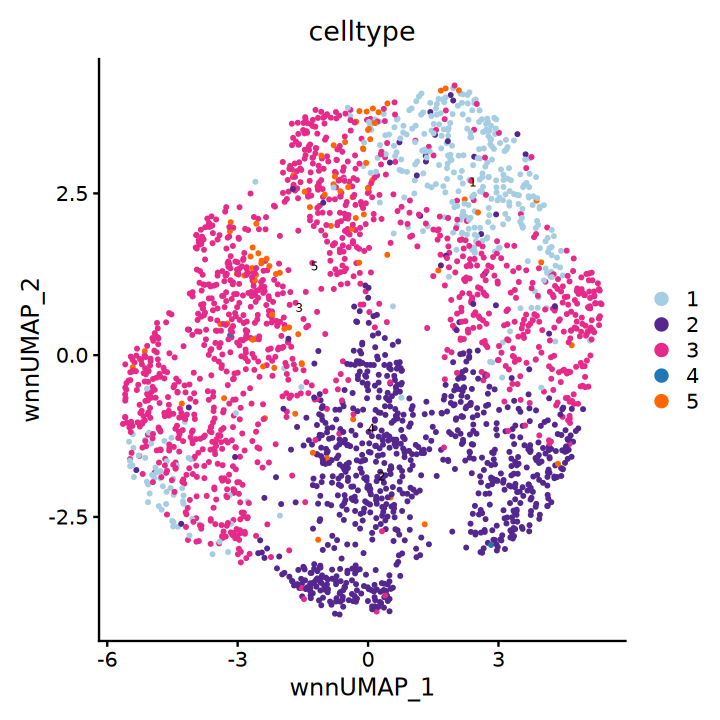

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered, reduction = "wnn.umap", group.by = "celltype", label = TRUE, label.size = 2.5, repel = TRUE,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600')) 

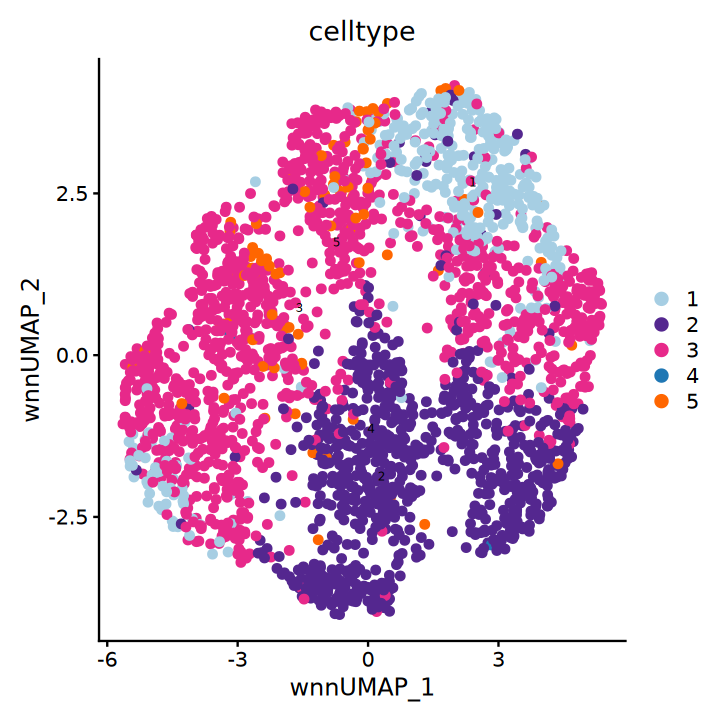

In [9]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered, reduction = "wnn.umap", group.by = "celltype", label = TRUE, label.size = 2.5, repel = TRUE,pt.size=2,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600')) 

In [10]:
pdf('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_umap.pdf',width=6,height=6)
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered, reduction = "wnn.umap", group.by = "celltype",pt.size=2, label = TRUE, label.size = 2.5, repel = TRUE,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600'))
dev.off()

png 
  2

In [ ]:
saveRDS(sc_filtered,file='/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/sc_multiome_filtered.rds')

In [1]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [13]:
sc_filtered <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/sc_multiome_filtered.rds')

In [14]:
sc_filtered

An object of class Seurat 
187457 features across 2508 samples within 2 assays 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 4 dimensional reductions calculated: lsi, umap, pca, wnn.umap

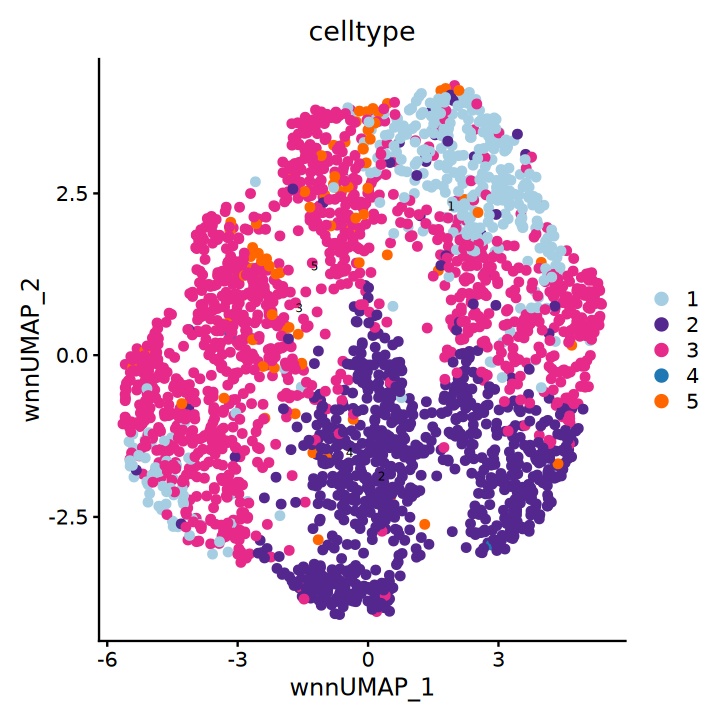

In [23]:
options(repr.plot.width = 6, repr.plot.height = 6)
DimPlot(sc_filtered, reduction = "wnn.umap", group.by = "celltype", label = TRUE, label.size = 2.5, repel = TRUE,pt.size=2,cols = c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600')) 

In [16]:
new_lineageGrp <- read.table('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/new_lineageGrp.csv',sep=',',row.names = 2,header = T)
rownames(new_lineageGrp) <- paste0('C',rownames(new_lineageGrp))
new_lineageGrp$new_lineageGrp <- paste0('C',new_lineageGrp$new_lineageGrp)

cell_lineage <- read.table('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cell_lineage_alignment.csv',header = T,sep=',',row.names = 1)
rownames(cell_lineage) <- paste0(rownames(cell_lineage),'-1')
cell_lineage$lineageGrp <- paste0('C',cell_lineage$lineageGrp)
cell_lineage$lineageGrp <- new_lineageGrp[cell_lineage$lineageGrp,'new_lineageGrp']
cell_lineage

lineageGrp num
CTTGCATGTGGGAACA-1 C50        126
CTGGCTTTCTTGCTAT-1 C50        122
AAGCCACGTATTTGCC-1 C50        108
TCATACTTCGCAACAT-1 C50        108
CCTAATAAGGGCTAAA-1 C50        104
GGTAATTGTTTATCGC-1 C50        103
TTGTGCGAGATACTTG-1 C50        103
ATGAAGTAGGTGCGGA-1 C50        102
ACGTCCAAGTGAGAGC-1 C50         89
CCTATAGCACGGTACT-1 C1          88
GATCGAGCAAGTGAAC-1 C4          87
TATGCATCACTCAACA-1 C50         87
CGCATTTGTAGTTACG-1 C1          85
TATCGCACATTAGGTT-1 C50         79
AATGCATGTAGCCTCC-1 C50         79
GGGAATATCCCTGATC-1 C50         79
GGTTATATCTAGCGTG-1 C50         78
GAGCGATAGTAGGCGG-1 C50         76
CACGCTAAGTTCCTCA-1 C50         72
ACGAGTAAGACAAGTG-1 C50         70
TTTGTCTAGGCAAGTA-1 C50         69
CCAAGTTAGCTTTGTT-1 C50         68
AGGATATAGTGTTGTA-1 C1          67
TGAAGGATCGCAGGCT-1 C50         67
GGTACCGGTCACGGAT-1 C1          67
GGTACCGGTTGGTTGA-1 C72         66
CTTCACTCACAAACTT-1 C3          65
GTGCTGATCGTAACGT-1 C138        64
GAGCCTTCAAACATAG-1 C138        64
CATCAATCAGGCTTCG-1 C4          64
⋮                  ⋮          ⋮  
GTTCCCAGTTAAATGC-1 C72        2  
GTTCATTTCCCGAAGC-1 C1         2  
AGCCGGTTCTCACACC-1 C72        2  
GTTAACCAGATTCCTT-1 C72        2  
AGTGGACAGGCGTAAA-1 C1         2  
TGGCCAATCCGCCTAT-1 C42        2  
TGGATTGGTCAGTAAT-1 C1         2  
GGTTGCATCCTGATTT-1 C1         2  
TGCTTGCTCGCATCCT-1 C109       2  
GGTTGCGGTTAACACG-1 C72        2  
TGCGCGAGTACGGTAC-1 C1         2  
ATGCGATTCCCGTTGT-1 C1         2  
TAACCGGTCTAGCGTG-1 C1         2  
AAGCCTCCAGCAAGTG-1 C109       2  
ATTCAACCACAAAGCG-1 C1         2  
TTAGCAATCTACCTCA-1 C109       2  
AACTAGTGTGAAACAA-1 C109       2  
ATTGCTCGTTTGAGGC-1 C1         2  
ATTGAAGCAATAATCC-1 C1         2  
ATTCAACCATACTCCT-1 C1         2  
AAGAATCAGTTGCCTC-1 C109       2  
GCCTTGCGTAATGACT-1 C6         2  
TGATCCTGTGCTTACT-1 C72        2  
GATTGCAGTCATGCAA-1 C109       2  
GATTGGCGTCCTAACT-1 C72        2  
GATTTGCAGTGCTGTG-1 C109       2  
GCCATTACATAAAGCA-1 C72        2  
GCCCTCATCCGCAAAT-1 C1         2  
ATGGCTAGTTTGCTGT-1 C138       2  
AATTGGGAGTGAACCT-1 C1         2

In [17]:
sc_filtered@meta.data$lineageGrp <- cell_lineage[rownames(sc_filtered@meta.data),'lineageGrp']
sc_filtered@meta.data

orig.ident    nCount_RNA nFeature_RNA percent.mt nCount_ATAC
AAACAGCCAGGCCATT-1 SeuratProject 59551      7443         13.784823  272842     
AAACATGCACCCTCAC-1 SeuratProject 11605      3726         10.616114  122571     
AAACATGCAGGCTACT-1 SeuratProject 17110      4312         17.790766   95600     
AAACCGCGTCTTGCTG-1 SeuratProject 17681      4030         19.048696   77848     
AAACCGCGTGGTTCTT-1 SeuratProject  9953      2879         18.486888   81446     
AAACCGGCAAGGACCA-1 SeuratProject 14510      3859          8.421778   72373     
AAACCGGCACAAAGGT-1 SeuratProject 15852      3900         17.612920  181208     
AAACCGGCAGTGAACG-1 SeuratProject 10179      3167         15.404264  101477     
AAACGGATCCAGGTTG-1 SeuratProject  4291      1636          8.109998   25099     
AAACGGATCCTGATGG-1 SeuratProject 37895      5984         12.157277  202025     
AAACGTACAATATGGA-1 SeuratProject 15015      3883         13.979354   82261     
AAAGCACCAATAAGCA-1 SeuratProject 14586      3780         10.681475   89281     
AAAGCCGCAAATTGCT-1 SeuratProject 12989      3907          5.389175  114729     
AAAGCCGCAGCCTGCA-1 SeuratProject 20304      5766          2.920607  139332     
AAAGGACGTCATTGAG-1 SeuratProject 15113      3944          4.161980   70418     
AAAGGACGTGACATGC-1 SeuratProject 40106      6038         10.384980  277869     
AAAGGAGCATGTTGTG-1 SeuratProject 11116      3360         10.687298  112675     
AAAGGCTCAAACTGCC-1 SeuratProject  7039      2421         12.146612   65614     
AAAGGCTCAGGTATTT-1 SeuratProject 25482      5235         13.935327  113877     
AAAGGTTAGCGTGCAC-1 SeuratProject 10606      3352          6.232321  128217     
AAAGGTTAGCTCGCTT-1 SeuratProject  6724      2126         13.518739   82701     
AAAGGTTAGGAGGTTA-1 SeuratProject 15783      4362         11.119559  248602     
AAATCCGGTTAGGTGC-1 SeuratProject 18009      4379         15.186851  120439     
AAATGCCTCTACCTCA-1 SeuratProject 11809      3499         19.773054   50027     
AAATGGCCAAGTGAAC-1 SeuratProject 15007      3901         17.471846   81204     
AAATGGCCAGGTATTT-1 SeuratProject 22042      4807         19.222394   95817     
AAATGGCCATAAGTCT-1 SeuratProject  8803      2761         14.585937   57047     
AACAAAGGTACGCGCA-1 SeuratProject 11939      3544          4.154452  118055     
AACAAAGGTGTTAAAC-1 SeuratProject 12284      3576          8.498860  200771     
AACAGATAGGATTTGC-1 SeuratProject 12255      3479         11.619747   50649     
⋮                  ⋮             ⋮          ⋮            ⋮          ⋮          
TTTAGGATCCCTCAGT-1 SeuratProject  9578      3250         17.174776  126069     
TTTAGGATCTACCTCA-1 SeuratProject  9532      2892          4.479648   51986     
TTTATGGAGGCTAAGA-1 SeuratProject 14411      3768         14.412601  125446     
TTTCATCAGACAACAG-1 SeuratProject  7866      2611          8.212560   92925     
TTTCATCAGCCTGGTA-1 SeuratProject 14055      3850         18.335112  163442     
TTTCATCAGGACTAAG-1 SeuratProject  7689      2545         18.532969   58319     
TTTCATCAGTCCTTTG-1 SeuratProject 25654      5290         11.608326  152893     
TTTCCACCATAATCAC-1 SeuratProject 14144      3841         11.262726   88999     
TTTCCTGAGCTATTGA-1 SeuratProject 10525      3358         14.603325   98519     
TTTCCTGAGTCTGGGC-1 SeuratProject 14574      3644         16.145190   67335     
TTTCGTCCACAGCCAT-1 SeuratProject 16125      3809         15.435659   61991     
TTTCGTCCACGTAATT-1 SeuratProject  8143      2742          5.071841   77193     
TTTCTTGCAACCTAAT-1 SeuratProject 25517      5404         11.016185  140032     
TTTCTTGCACCGGTAT-1 SeuratProject 21426      4709         14.753104   85243     
TTTGACTTCAAGACTC-1 SeuratProject 12770      3692          9.373532   81474     
TTTGACTTCTGTGAGT-1 SeuratProject 13206      3458         17.802514  104691     
TTTGAGTCACCATATG-1 SeuratProject 26575      5140         12.041392  144641     
TTTGCATTCAAGCCTG-1 SeuratProject 10074      2718          9.837205   72721     
TTTGCATTCATTACAG-1 

In [20]:
sc_filtered@meta.data

orig.ident    nCount_RNA nFeature_RNA percent.mt nCount_ATAC
AAACAGCCAGGCCATT-1 SeuratProject 59551      7443         13.784823  272842     
AAACATGCACCCTCAC-1 SeuratProject 11605      3726         10.616114  122571     
AAACATGCAGGCTACT-1 SeuratProject 17110      4312         17.790766   95600     
AAACCGCGTCTTGCTG-1 SeuratProject 17681      4030         19.048696   77848     
AAACCGCGTGGTTCTT-1 SeuratProject  9953      2879         18.486888   81446     
AAACCGGCAAGGACCA-1 SeuratProject 14510      3859          8.421778   72373     
AAACCGGCACAAAGGT-1 SeuratProject 15852      3900         17.612920  181208     
AAACCGGCAGTGAACG-1 SeuratProject 10179      3167         15.404264  101477     
AAACGGATCCAGGTTG-1 SeuratProject  4291      1636          8.109998   25099     
AAACGGATCCTGATGG-1 SeuratProject 37895      5984         12.157277  202025     
AAACGTACAATATGGA-1 SeuratProject 15015      3883         13.979354   82261     
AAAGCACCAATAAGCA-1 SeuratProject 14586      3780         10.681475   89281     
AAAGCCGCAAATTGCT-1 SeuratProject 12989      3907          5.389175  114729     
AAAGCCGCAGCCTGCA-1 SeuratProject 20304      5766          2.920607  139332     
AAAGGACGTCATTGAG-1 SeuratProject 15113      3944          4.161980   70418     
AAAGGACGTGACATGC-1 SeuratProject 40106      6038         10.384980  277869     
AAAGGAGCATGTTGTG-1 SeuratProject 11116      3360         10.687298  112675     
AAAGGCTCAAACTGCC-1 SeuratProject  7039      2421         12.146612   65614     
AAAGGCTCAGGTATTT-1 SeuratProject 25482      5235         13.935327  113877     
AAAGGTTAGCGTGCAC-1 SeuratProject 10606      3352          6.232321  128217     
AAAGGTTAGCTCGCTT-1 SeuratProject  6724      2126         13.518739   82701     
AAAGGTTAGGAGGTTA-1 SeuratProject 15783      4362         11.119559  248602     
AAATCCGGTTAGGTGC-1 SeuratProject 18009      4379         15.186851  120439     
AAATGCCTCTACCTCA-1 SeuratProject 11809      3499         19.773054   50027     
AAATGGCCAAGTGAAC-1 SeuratProject 15007      3901         17.471846   81204     
AAATGGCCAGGTATTT-1 SeuratProject 22042      4807         19.222394   95817     
AAATGGCCATAAGTCT-1 SeuratProject  8803      2761         14.585937   57047     
AACAAAGGTACGCGCA-1 SeuratProject 11939      3544          4.154452  118055     
AACAAAGGTGTTAAAC-1 SeuratProject 12284      3576          8.498860  200771     
AACAGATAGGATTTGC-1 SeuratProject 12255      3479         11.619747   50649     
⋮                  ⋮             ⋮          ⋮            ⋮          ⋮          
TTTAGGATCCCTCAGT-1 SeuratProject  9578      3250         17.174776  126069     
TTTAGGATCTACCTCA-1 SeuratProject  9532      2892          4.479648   51986     
TTTATGGAGGCTAAGA-1 SeuratProject 14411      3768         14.412601  125446     
TTTCATCAGACAACAG-1 SeuratProject  7866      2611          8.212560   92925     
TTTCATCAGCCTGGTA-1 SeuratProject 14055      3850         18.335112  163442     
TTTCATCAGGACTAAG-1 SeuratProject  7689      2545         18.532969   58319     
TTTCATCAGTCCTTTG-1 SeuratProject 25654      5290         11.608326  152893     
TTTCCACCATAATCAC-1 SeuratProject 14144      3841         11.262726   88999     
TTTCCTGAGCTATTGA-1 SeuratProject 10525      3358         14.603325   98519     
TTTCCTGAGTCTGGGC-1 SeuratProject 14574      3644         16.145190   67335     
TTTCGTCCACAGCCAT-1 SeuratProject 16125      3809         15.435659   61991     
TTTCGTCCACGTAATT-1 SeuratProject  8143      2742          5.071841   77193     
TTTCTTGCAACCTAAT-1 SeuratProject 25517      5404         11.016185  140032     
TTTCTTGCACCGGTAT-1 SeuratProject 21426      4709         14.753104   85243     
TTTGACTTCAAGACTC-1 SeuratProject 12770      3692          9.373532   81474     
TTTGACTTCTGTGAGT-1 SeuratProject 13206      3458         17.802514  104691     
TTTGAGTCACCATATG-1 SeuratProject 26575      5140         12.041392  144641     
TTTGCATTCAAGCCTG-1 SeuratProject 10074      2718          9.837205   72721     
TTTGCATTCATTACAG-1 

In [22]:
sc_filtered@assays$RNA@layers$data <- NULL
sc_filtered@assays$RNA@layers$scale.data <- NULL

In [25]:
saveRDS(sc_filtered,file='/syn1/liangzhen/jinhua_jilab_project/data/tmp/sc_multiome_filtered.rds')

In [26]:
sc_filtered@meta.data

orig.ident    nCount_RNA nFeature_RNA percent.mt nCount_ATAC
AAACAGCCAGGCCATT-1 SeuratProject 59551      7443         13.784823  272842     
AAACATGCACCCTCAC-1 SeuratProject 11605      3726         10.616114  122571     
AAACATGCAGGCTACT-1 SeuratProject 17110      4312         17.790766   95600     
AAACCGCGTCTTGCTG-1 SeuratProject 17681      4030         19.048696   77848     
AAACCGCGTGGTTCTT-1 SeuratProject  9953      2879         18.486888   81446     
AAACCGGCAAGGACCA-1 SeuratProject 14510      3859          8.421778   72373     
AAACCGGCACAAAGGT-1 SeuratProject 15852      3900         17.612920  181208     
AAACCGGCAGTGAACG-1 SeuratProject 10179      3167         15.404264  101477     
AAACGGATCCAGGTTG-1 SeuratProject  4291      1636          8.109998   25099     
AAACGGATCCTGATGG-1 SeuratProject 37895      5984         12.157277  202025     
AAACGTACAATATGGA-1 SeuratProject 15015      3883         13.979354   82261     
AAAGCACCAATAAGCA-1 SeuratProject 14586      3780         10.681475   89281     
AAAGCCGCAAATTGCT-1 SeuratProject 12989      3907          5.389175  114729     
AAAGCCGCAGCCTGCA-1 SeuratProject 20304      5766          2.920607  139332     
AAAGGACGTCATTGAG-1 SeuratProject 15113      3944          4.161980   70418     
AAAGGACGTGACATGC-1 SeuratProject 40106      6038         10.384980  277869     
AAAGGAGCATGTTGTG-1 SeuratProject 11116      3360         10.687298  112675     
AAAGGCTCAAACTGCC-1 SeuratProject  7039      2421         12.146612   65614     
AAAGGCTCAGGTATTT-1 SeuratProject 25482      5235         13.935327  113877     
AAAGGTTAGCGTGCAC-1 SeuratProject 10606      3352          6.232321  128217     
AAAGGTTAGCTCGCTT-1 SeuratProject  6724      2126         13.518739   82701     
AAAGGTTAGGAGGTTA-1 SeuratProject 15783      4362         11.119559  248602     
AAATCCGGTTAGGTGC-1 SeuratProject 18009      4379         15.186851  120439     
AAATGCCTCTACCTCA-1 SeuratProject 11809      3499         19.773054   50027     
AAATGGCCAAGTGAAC-1 SeuratProject 15007      3901         17.471846   81204     
AAATGGCCAGGTATTT-1 SeuratProject 22042      4807         19.222394   95817     
AAATGGCCATAAGTCT-1 SeuratProject  8803      2761         14.585937   57047     
AACAAAGGTACGCGCA-1 SeuratProject 11939      3544          4.154452  118055     
AACAAAGGTGTTAAAC-1 SeuratProject 12284      3576          8.498860  200771     
AACAGATAGGATTTGC-1 SeuratProject 12255      3479         11.619747   50649     
⋮                  ⋮             ⋮          ⋮            ⋮          ⋮          
TTTAGGATCCCTCAGT-1 SeuratProject  9578      3250         17.174776  126069     
TTTAGGATCTACCTCA-1 SeuratProject  9532      2892          4.479648   51986     
TTTATGGAGGCTAAGA-1 SeuratProject 14411      3768         14.412601  125446     
TTTCATCAGACAACAG-1 SeuratProject  7866      2611          8.212560   92925     
TTTCATCAGCCTGGTA-1 SeuratProject 14055      3850         18.335112  163442     
TTTCATCAGGACTAAG-1 SeuratProject  7689      2545         18.532969   58319     
TTTCATCAGTCCTTTG-1 SeuratProject 25654      5290         11.608326  152893     
TTTCCACCATAATCAC-1 SeuratProject 14144      3841         11.262726   88999     
TTTCCTGAGCTATTGA-1 SeuratProject 10525      3358         14.603325   98519     
TTTCCTGAGTCTGGGC-1 SeuratProject 14574      3644         16.145190   67335     
TTTCGTCCACAGCCAT-1 SeuratProject 16125      3809         15.435659   61991     
TTTCGTCCACGTAATT-1 SeuratProject  8143      2742          5.071841   77193     
TTTCTTGCAACCTAAT-1 SeuratProject 25517      5404         11.016185  140032     
TTTCTTGCACCGGTAT-1 SeuratProject 21426      4709         14.753104   85243     
TTTGACTTCAAGACTC-1 SeuratProject 12770      3692          9.373532   81474     
TTTGACTTCTGTGAGT-1 SeuratProject 13206      3458         17.802514  104691     
TTTGAGTCACCATATG-1 SeuratProject 26575      5140         12.041392  144641     
TTTGCATTCAAGCCTG-1 SeuratProject 10074      2718          9.837205   72721     
TTTGCATTCATTACAG-1 

In [27]:
write.table(sc_filtered@meta.data,file = '/syn1/liangzhen/jinhua_jilab_project/data/tmp/metadata_sc_multiome.csv',sep=',',col.names = NA,quote=F)

In [5]:
options(repr.plot.width = 5, repr.plot.height = 5) 
sc_filtered@meta.data <- cbind(sc_filtered@meta.data,
                      as.data.frame(sc_filtered@reductions$wnn.umap@cell.embeddings)[rownames(sc_filtered@meta.data),])

In [8]:
table(sc_filtered@meta.data[!is.na(sc_filtered@meta.data$lineageGrp) & sc_filtered@meta.data$lineageGrp == 'C1','celltype'])


  1   2   3   5 
 66 113 236  27 

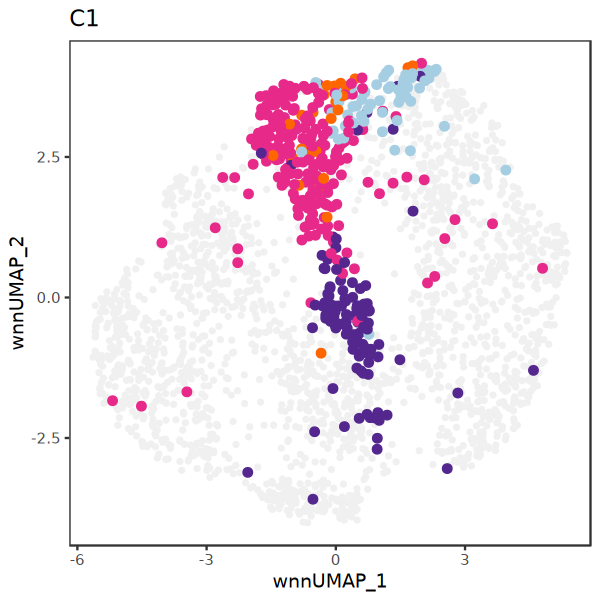

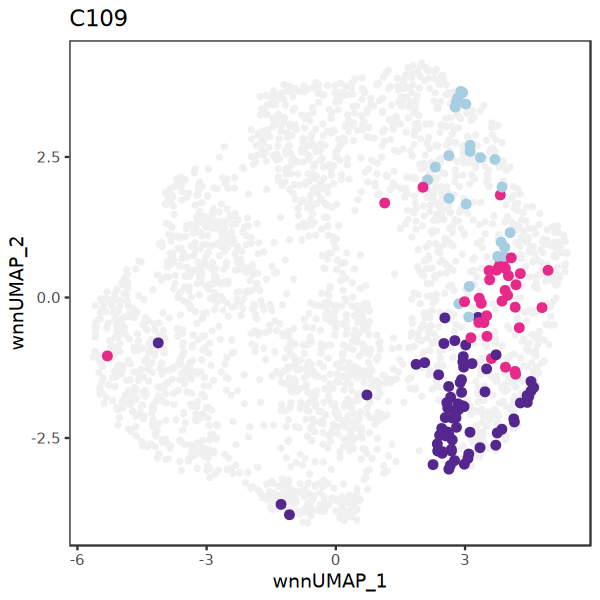

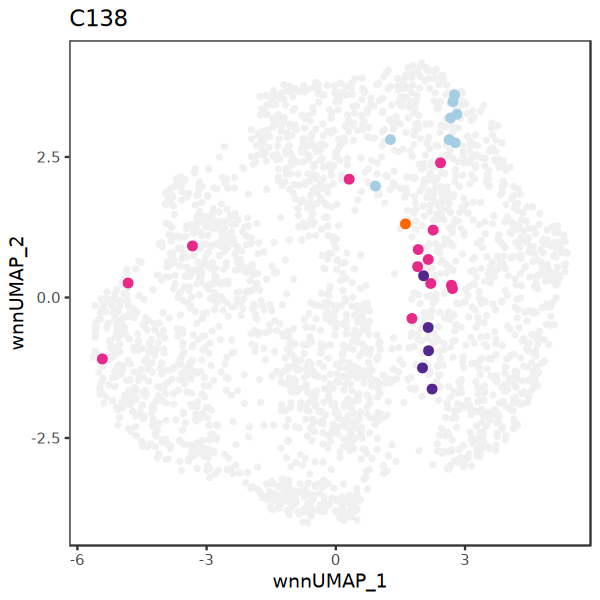

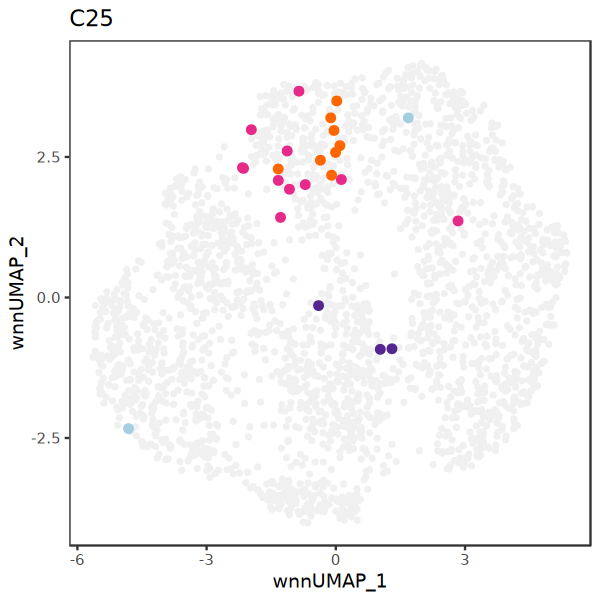

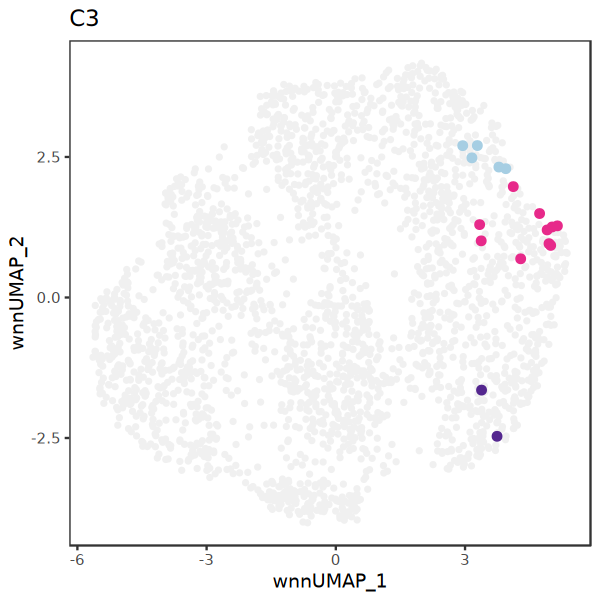

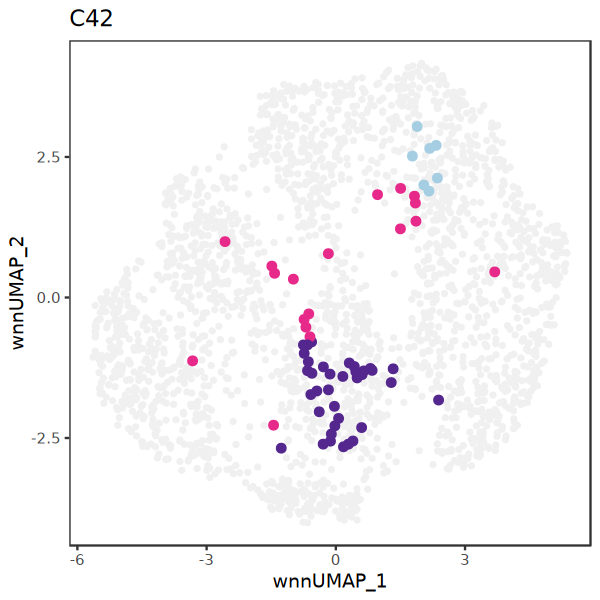

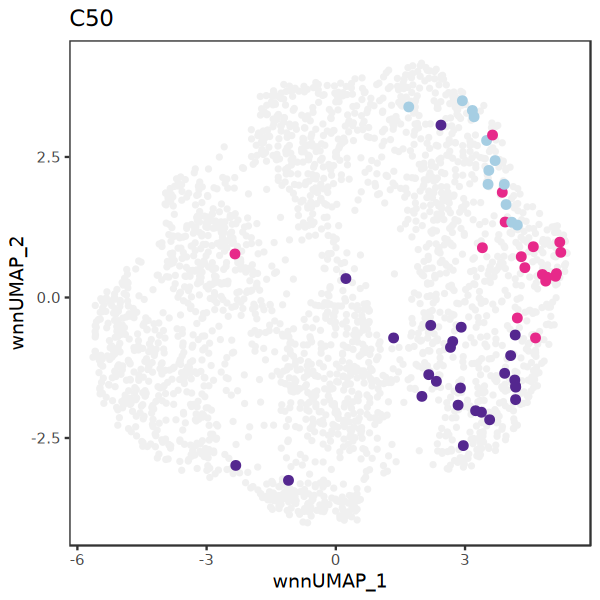

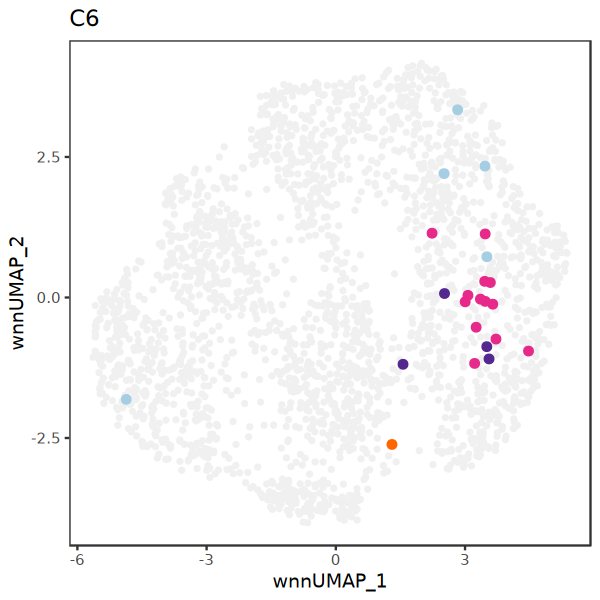

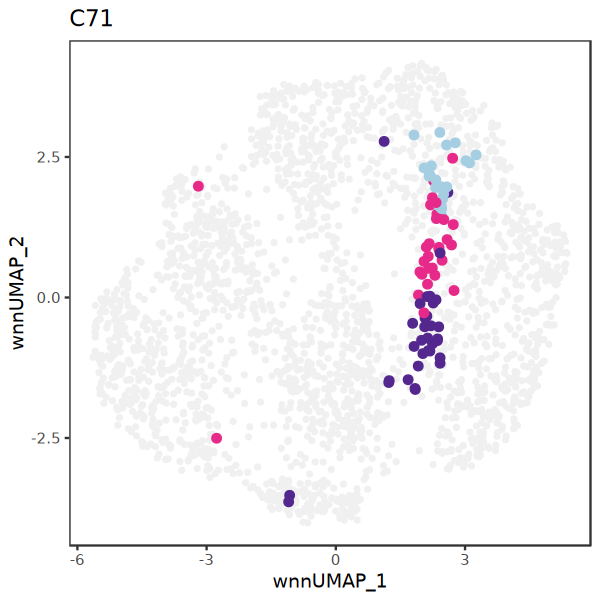

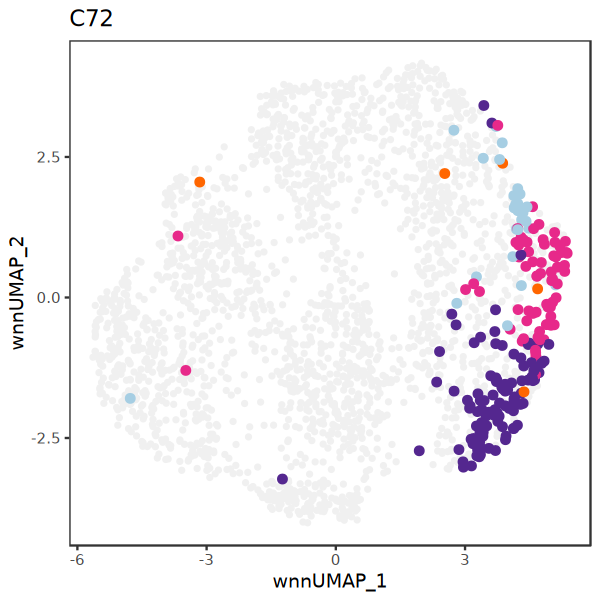

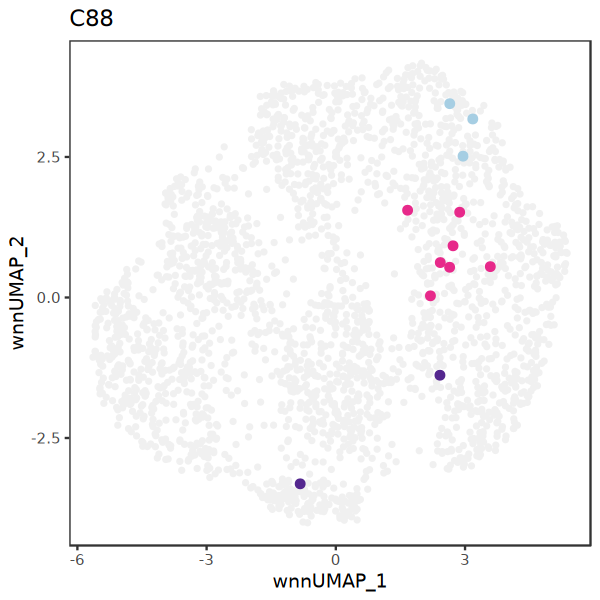

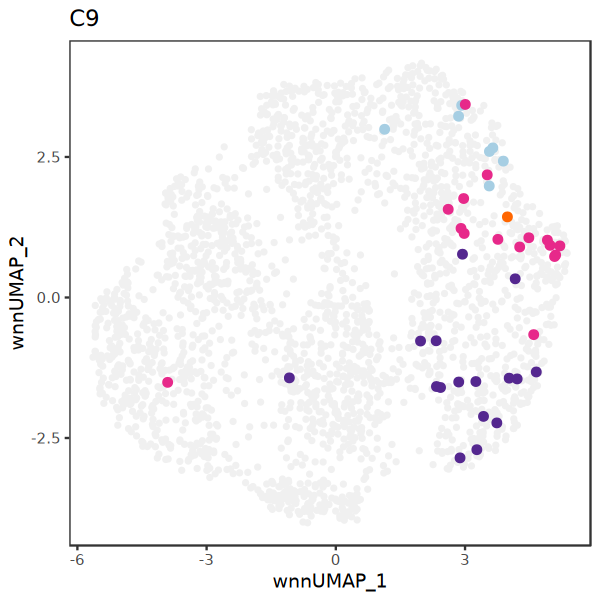

In [7]:
for (multi_state_clones in names(table(sc_filtered@meta.data$lineageGrp)[table(sc_filtered@meta.data$lineageGrp)>10])){    
    sc_filtered@meta.data$seurat_clusters_col <- as.character(sc_filtered@meta.data$celltype)
    sc_filtered@meta.data[! (sc_filtered@meta.data$lineageGrp %in% multi_state_clones),'seurat_clusters_col'] <- 'bg'
    sc_filtered@meta.data$seurat_clusters_col <- factor(sc_filtered@meta.data$seurat_clusters_col,
                                                         levels = c('bg','1','2','3','4','5'))
    plot <- ggplot()+
        geom_point(data =sc_filtered@meta.data[sc_filtered@meta.data$seurat_clusters_col == 'bg',],aes(x=wnnUMAP_1,y=wnnUMAP_2),size=1,color='#f0f0f0') + 
        geom_point(data =sc_filtered@meta.data[sc_filtered@meta.data$seurat_clusters_col != 'bg',],aes(x=wnnUMAP_1,y=wnnUMAP_2,color=seurat_clusters_col),size=2)+
        scale_color_manual(
             breaks=c('1','2','3','4','5'),
             values=c('#a6cee3','#54278f','#e7298a','#1f77b4','#ff6600')
         )+ ggtitle(multi_state_clones) + theme_bw()+
        theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank()) + theme(legend.position = 'none')

    print(plot) 
    ggsave(
      filename = paste0('/syn1/liangzhen/jinhua_jilab_project/result/Figures/Figure6/multiome_',multi_state_clones,'_umap.pdf'), 
      width = 5,             # 宽
      height = 5
    )    
}
